# Лабораторная робата №1
## Расстояние Жаккарда
### выполнил: Лукин А.В.

**Цель работы:** разработать программу на языке программирования Python, обрабатывающую тексты и определяющая их сходство по расстоянию Жаккарда (Жаккара).

* Входные данные: 50 текстов объемом от 10 предложений каждое. Сбор данных – автоматизированный или ручной – по желанию студента. Исходные тексты, собранные в ручную, должны храниться в файле формата по выбору студента (.csv, .json, .xlsx и т.д.)
* Выходные данные: тепловая карта сходства (heatmap) текстов 50 на 50.


#### Для анализа текстов, будут использованы новостные тексты с сайта ЦБ РФ *https://www.cbr.ru/*.
**Суть данной работы, проверить качество работы по написанию новостей и их эксклюзивность.**

Сбор данных автоматизированный, при помощи библиотек *bs4*, *lxml* и *requests*.
Правила отбора новостей:
* Только на русском языке;
* Сохранять файлы будут в json;
* Сразу в название замена nbsp на ' '.

Переход будет производиться по id новостей, т.к. переход с главной страницы сайта затруднён.
url-agent использоваться не будет, т.к. нет никакой защиты.

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import re

In [2]:
# for id_ in range(1, 1500):                                                                # рандомно выбрал кол-во id, можно больше или меньше
#     URL = f'https://www.cbr.ru/press/event/?id={id_}'
#     html = requests.get(URL, params={'Date': '13-Feb-2022'}).text
#     soup = BeautifulSoup(html, 'lxml')

    # title_for_file = soup.find("h1").find("span", class_="referenceable").text

    # if (title_for_file == "Новость") or len(re.findall(r'[a-zA-Z]', title_for_file)) > 0: # Англоязычные новости пропускаем и пустые, они имеют загловок "Новость"
    #     continue
    # else:
    #     title_for_file = title_for_file.replace(' ', ' ')                              # Это неразрывный пробел, заменяю на обычный, чтобы избежать возможные проблемы

    # text_for_file = soup.findAll("p")

    # try:
    #     with open(f"text_anal\\{title_for_file}.json", "w") as file:
    #         json.dump(str(text_for_file), file, indent=4, ensure_ascii=False)
    # except FileNotFoundError:
    #     continue
    # except UnicodeEncodeError:
    #     continue

После сбора данных их необходимо почистить, и оставить только те данные, которые подойдут для дальнейшего анализа.
Отсеиваться файлы будут меньше 4 кБ и больше 8 кБ.

In [3]:
import os

In [4]:
list_of_files = sorted(os.listdir('text_anal\\'))
count = 0
for file in list_of_files:
    if count == 51:
        os.remove(f'text_anal\\{file}')
        continue
    if os.stat(f'text_anal\\{file}').st_size < 3000 or os.stat(
            f'text_anal\\{file}').st_size > 8000:
        os.remove(f'text_anal\\{file}')
        continue
    count += 1

Следующим шагом будет подготовка дата сета. Которая состоит из следующих пунктов:
* Очистка от ссылок;
* Удаление элементов HTML-разметки;
* Замена nbsp на пробелы;
* Выполнить токенизацию;
* Выполнить нормализацию;
* Провести фильтрацию от слов, понижающих точность;
* Представить все слова в нижнем регистре;
* Избавиться от знаков препинания.

Для разбиения на токены используем библиотеку *NLTK* и импортируем для этого *word_tokenize*.
Для нахождения стоп слов подключим *stopwords* из *NLTK*:
И чтобы выполнить нормализацию, воспользуемся библиотекой *pymorphy2*

In [5]:
# import nltk
# nltk.download('punkt')
# from nltk.tokenize import word_tokenize

In [6]:
# nltk.download('stopwords')
# from nltk.corpus import stopwords

In [7]:
import nltk
from nltk.corpus import stopwords
import pymorphy2

In [8]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Без этого, обрезается строка.

In [9]:
pd.set_option('max_colwidth', 800000)

In [10]:
list_of_files = sorted(os.listdir('text_anal\\'))

df_cbr = pd.DataFrame(columns=['title', 'text'])

for file in list_of_files:
    text_for_redact = pd.read_json(open(f'text_anal\\{file}', encoding='cp1251'), lines=True)

    cleaned_text = re.sub(re.compile('<.*?>'), '', str(text_for_redact[0]))
    cleaned_text = re.sub(r'[^А-Яа-я]+', ' ', cleaned_text)
    cleaned_text = cleaned_text.lower()

    tokens = nltk.word_tokenize(cleaned_text)

    stop_words = stopwords.words('russian')
    filter_text = [word for word in tokens if word not in stop_words]

    morph = pymorphy2.MorphAnalyzer()
    normalized_text = [morph.parse(word)[0].normal_form for word in filter_text]

    to_df = [word for word in normalized_text if word not in ['финансовый', 'банк', 'россия', 'год', 'также', 'это', 'российский', 'они', 'твой', 'г', 'этот', 'п', 'однако', 'н', 'анна', 'так', 'м', 'борисович', 'калманский', 'ксения', 'анатолий', 'хоменко', 'екатерина', 'галина', 'ольга', 'наталья', 'бугринский', 'анатолиевич', 'ирина', 'василиевич', 'николаевич', 'коршунов', 'елена', 'шубин', 'надежда', 'малков', 'юлаева', 'лизюков', 'игорь', 'васильев', 'несмотря', 'хотя', 'чумаченко', 'горяев', 'третьяк', 'ларионов', 'лунтовский', 'авгеев', 'юриевич', 'плеханов', 'буинский', 'карим', 'рафаисович', 'людиновский', 'сидоренко', 'григорий', 'нежели', 'таков', 'козлов', 'гарченко', 'ф', 'марина', 'иванович', 'василий', 'сей', 'дмитрий', 'климишин', 'иван', 'андрей', 'гузновый', 'моисеев', 'инна', 'о', 'гончаров', 'левицкий', 'евгений', 'машук', 'вика', 'илья', 'л', 'власов', 'что', 'к', 'э', 'александр', 'январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']]

    df_cbr = df_cbr.append({'title': f'{file[:-5]}', 'text': to_df}, ignore_index=True)
    # df_cbr = df_cbr.append({'title': f'{file[:-5]}', 'text': normalized_text}, ignore_index=True)

df_cbr.to_csv('cbr.csv', encoding='cp1251', index=False)

Сохраняем файл в csv, чтобы потом не обрабатывать все текста заново.

In [11]:
df_cbr = pd.read_csv('cbr.csv', encoding='cp1251', converters={"text": lambda x: x.strip("[]").replace("'","").split(", ")})
df_cbr

,title,text
0,Банк России займется повышением финансовой доступности для людей с инвалидностью,"[услуга, инструмент, стать, доступный, лицо, ограниченный, возможность, здоровье, потребоваться, технический, решение, число, область, технология, позволять, преодолеть, существующий, барьер, внесение, изменение, действовать, законодательство, нормативный, акт, разработка, мера, заниматься, рабочий, группа, повышение, доступность, лицо, ограниченный, возможность, здоровье, создать, ход, встреча, руководство, регулятор, представитель, орган, власть, участник, рынок, общественный, объединение, человек, инвалидность, уверить, должный, работать, направление, искоренение, барьер, который, возникать, обращение, человек, инвалидность, услуга, суть, дело, физический, ограничение, становиться, препятствие, человек, получить, услуга, неприспособленный, среда, институт, отметить, свой, выступление, председатель, эльвира, набиуллин, пример, институт, обращать, внимание, вопрос, пока, очень, мало, доступность, услуга, очень, высокий, считать, направление, важный, значит, такой, ситуация, должный, поменяться, давление, ...]"
1,Банк России и Министерство образования и науки подписали соглашение о сотрудничестве,"[подписать, соглашение, сотрудничество, министерство, образование, наука, область, повышение, грамотность, население, федерация, документ, подписать, первый, заместитель, министр, образование, наука, первый, заместитель, председатель, сергей, швецов, соглашение, предполагать, взаимодействие, работа, продвижение, основа, грамотность, образовательный, система, частность, участие, специалист, методический, сопровождение, реализация, федеральный, государственный, образовательный, стандарт, область, грамотность, течение, три, месяц, подписание, разработать, дорожный, карта, план, конкретный, мероприятие, реализация, соглашение, подписание, данный, соглашение, стать, результат, наш, многолетний, работа, направить, формирование, грамотность, школьник, отметить, первый, заместитель, министр, образование, наука, федерация, современный, школа, должный, давать, крепкий, академический, знание, должный, готовить, выпускник, взрослый, жизнь, наш, ребёнок, должный, иметь, тот, знание, который, безусловно, пригодиться, практика, сегодня, примерный, образовательный, ...]"
2,Банк России и Минобрнауки РФ приступят к выполнению совместного плана по повышению уровня финансовой грамотности россиян,"[председатель, эльвира, набиуллин, министр, образование, наука, рф, подписать, дорожный, карта, мероприятие, включение, грамотность, программа, образовательный, организация, церемония, подписание, дорожный, карта, состояться, московский, международный, салон, образование, ммсый, работа, который, впервые, принять, участие, согласно, документ, подготовить, межведомственный, рабочий, группа, быть, разработать, предложение, преподавание, основа, грамотность, дошкольный, учреждение, внести, изменение, существующий, программа, начальный, основный, среднее, среднее, профессиональный, высокий, образование, подготовить, методический, рекомендация, преподаватель, уровень, включая, дополнительный, образование, предложение, внесение, элемент, грамотность, контрольный, измерительный, материал, единый, государственный, экзамен, повышение, мотивация, учиться, преподаватель, предусмотреть, профессиональный, конкурс, тематический, олимпиада, вопрос, повышение, грамотность, иметь, первостепенный, значение, отметить, эльвира, набиуллин, исходить, современный, человек, должный, обладать, знание, практический, навык, ...]"
3,Банк России опубликовал Отчет о развитии банковского сектора и банковского надзора за 2015 год,"[банковский, сектор, целое, адаптироваться, сложный, макроэкономический, условие, сохранить, устойчивость, необходимый, удовлетворение, спрос, корпоративный, сектор, население, банковский, услуга, говориться, отчёт, развитие, банковский, сектор, банковский, надзор, итог, чистый, прибыль, кредитный, организация, составить, млрд, руб, млрд, руб, свидетельствовать, дать, отчё

На данном этапе проверим слова, которые нужно убрать:
* Которые часто повторяются;
* Частицы, предлоги, союзы, междометия и др.;
* Имена;
* Месяцы.

In [12]:
repeat_word = []
for index_, row_ in df_cbr.iterrows():
    for word_ in row_['text']:
        repeat_word.append(word_)

In [13]:
dict_repeat_word = dict(zip(list(repeat_word),[list(repeat_word).count(i) for i in list(repeat_word)]))
df_dict = pd.DataFrame([dict_repeat_word])
df_dict = df_dict.transpose()

In [14]:
df_dict

,0
услуга,113
инструмент,30
стать,25
доступный,6
лицо,61
...,...
валидация,1
категорирование,2
посредством,1
содействие,1


Запишем функцию, для расчёта коэффициента Жаккарда.

![fig. index Jaccard](af8dd7ca67bf35fe0e7c045f37b92aa0.jpeg)

In [15]:
def jaccard(text_a, text_b):
    shared = text_a.intersection(text_b)
    return len(shared) / len(text_a.union(text_b))

Создадим таблицу, для её последующего заполнения.

In [16]:
df_comp_jac = pd.DataFrame(columns=df_cbr['title'], index=df_cbr['title'])
df_comp_jac

title,Банк России займется повышением финансовой доступности для людей с инвалидностью,Банк России и Министерство образования и науки подписали соглашение о сотрудничестве,Банк России и Минобрнауки РФ приступят к выполнению совместного плана по повышению уровня финансовой грамотности россиян,Банк России опубликовал Отчет о развитии банковского сектора и банковского надзора за 2015 год,Банк России ответил на запрос Совета Федерации о регулировании деятельности МФО,Банк России открывает сайт по финансовой грамотности,Банк России отмечает снижение процентных ставок по потребительским кредитам и займам,Банк России поддерживает введение ответственности за создание «финансовых пирамид» и намерен активно выявлять подобные структуры в российских регионах,Банк России представил в Госдуму годовой отчет за 2016 год,Банк России проанализировал состояние финансовой доступности в России,...,Очищением финрынка и надзором за МФО займутся новые департаменты,Разработан механизм участия регулятора в санации банков,Разработана концепция регулирования краудфандинга в России,Разработаны требования к базовому стандарту защиты прав клиентов микрофинансовых организаций,Разработаны экономические нормативы для микрофинансовых и микрокредитных компаний,Рост кредитования малого бизнеса отмечен на краудфандинговых площадках,С нового года приобрести полис ОСАГО можно в виде электронного документа,Стартовала программа подготовки тьюторов для обучения основам финансовой грамотности,Стартует Всероссийский конкурс на лучшую образовательную программу по финансовой грамотности,Финансовому рынку предложено новое регулирование категорий инвесторов и определение их инвестиционного профиля
title,,,,,,,,,,,,,,,,,,,,,
Банк России займется повышением финансовой доступности для людей с инвалидностью,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Банк России и Министерство образования и науки подписали соглашение о сотрудничестве,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Банк России и Минобрнауки РФ приступят к выполнению совместного плана по повышению уровня финансовой грамотности россиян,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Банк России опубликовал Отчет о развитии банковского сектора и банковского надзора за 2015 год,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Банк России ответил на запрос Совета Федерации о регулировании деятельности МФО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Банк России открывает сайт по финансовой грамотности,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Банк России отмечает снижение процентных ставок по потребительским кредитам и займам,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Банк России поддерживает введение ответственности за создание «финансовых пирамид» и намерен активно выявлять подобные структуры в российских регионах,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Банк России представил в Госдуму годовой отчет за 2016 год,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заполним таблицу.

In [17]:
for index, row in df_cbr.iterrows():
    for index_copy, row_copy in df_cbr.iterrows():
        df_comp_jac[row_copy['title']].loc[df_comp_jac.index == row['title']] = (jaccard(set(row['text']), set(row_copy['text'])))

for i, r in df_comp_jac.iterrows():
    df_comp_jac[i] = pd.to_numeric(r)

df_comp_jac.index = [f'новость {i}' for i in range(1, 51)]
df_comp_jac.columns = [f'новость {i}' for i in range(1, 51)]

Построим heatmap, при помощи библиотеки *seaborn*.

<AxesSubplot:>

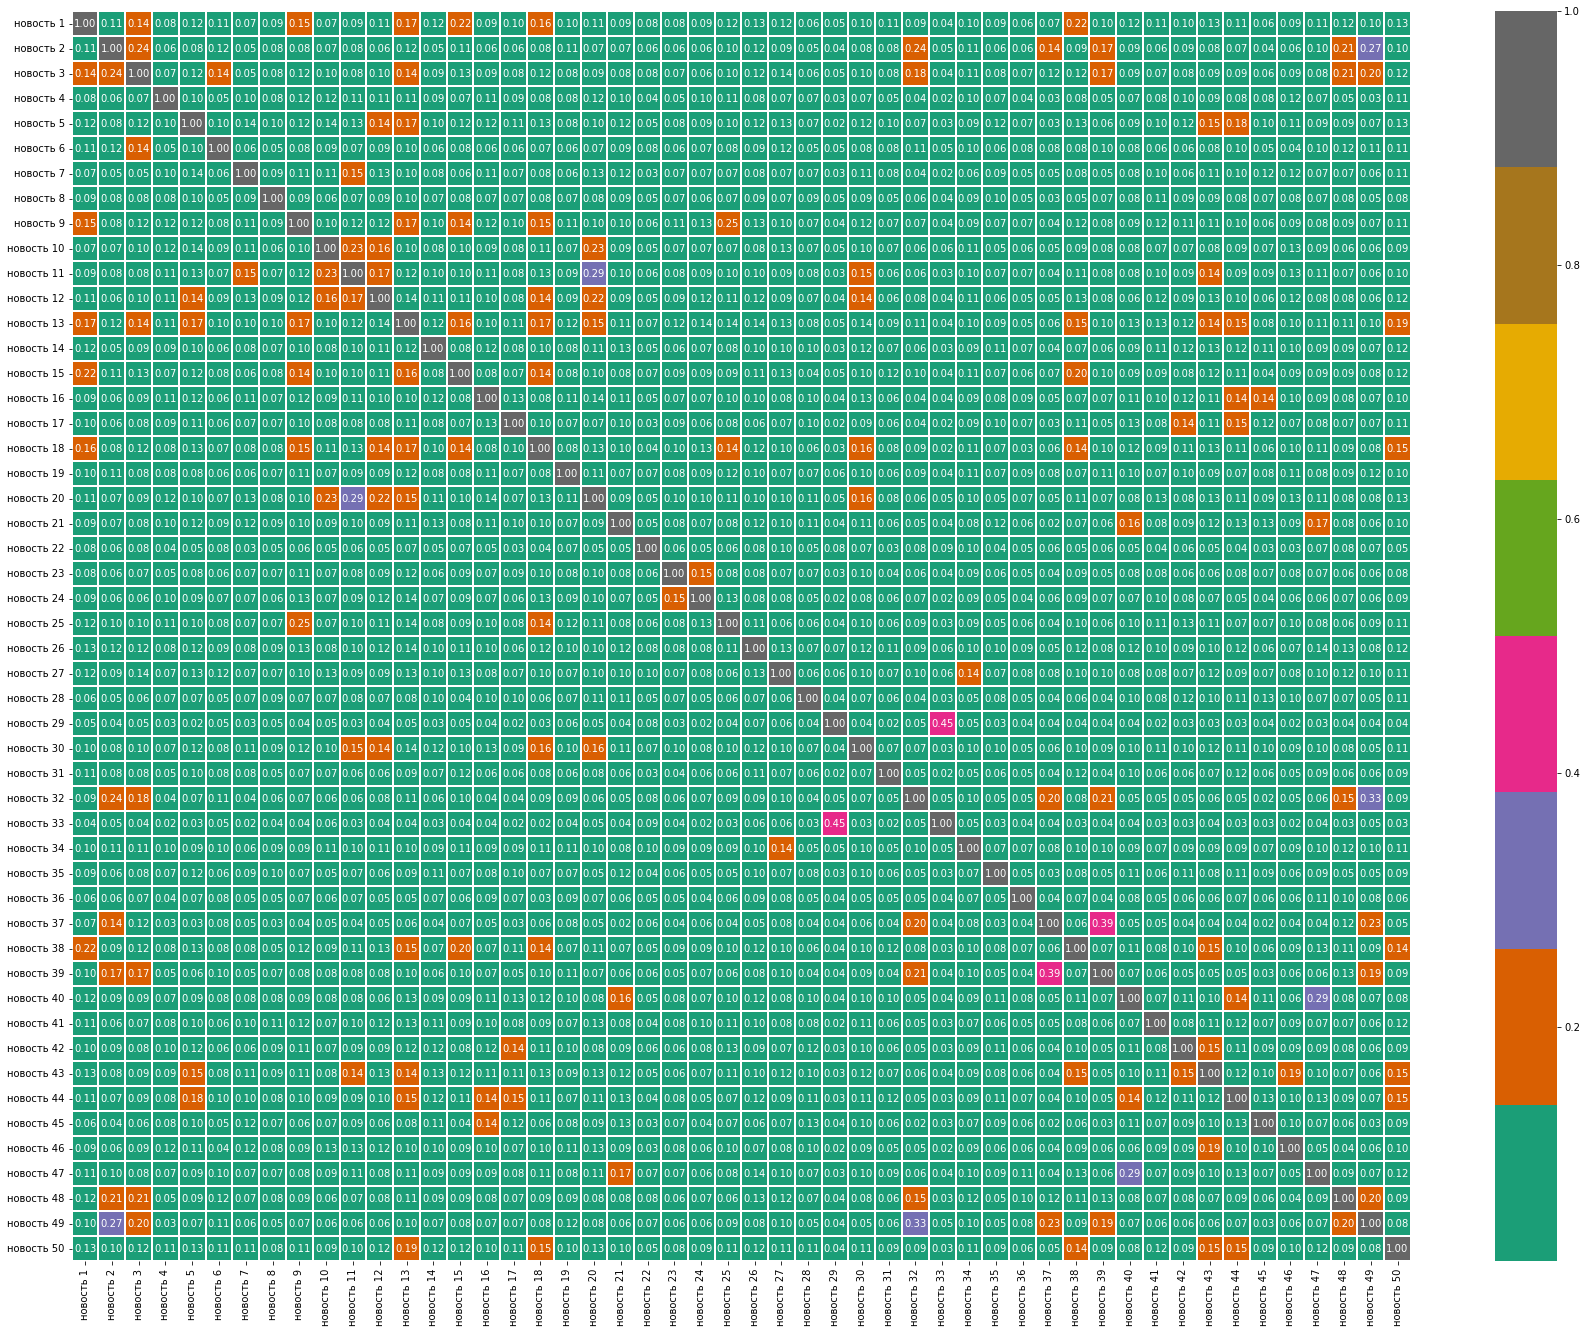

In [21]:
plt.subplots(figsize=(30,23))
sns.heatmap(df_comp_jac,
            annot=True,
            linewidths=.05,
            fmt=".2f",
            cmap="Dark2")

In [19]:
df_comp = pd.DataFrame([df_cbr['title'], df_comp_jac.index])
df_comp.transpose()

,title,Unnamed 0
0,Банк России займется повышением финансовой доступности для людей с инвалидностью,новость 1
1,Банк России и Министерство образования и науки подписали соглашение о сотрудничестве,новость 2
2,Банк России и Минобрнауки РФ приступят к выполнению совместного плана по повышению уровня финансовой грамотности россиян,новость 3
3,Банк России опубликовал Отчет о развитии банковского сектора и банковского надзора за 2015 год,новость 4
4,Банк России ответил на запрос Совета Федерации о регулировании деятельности МФО,новость 5
5,Банк России открывает сайт по финансовой грамотности,новость 6
6,Банк России отмечает снижение процентных ставок по потребительским кредитам и займам,новость 7
7,Банк России поддерживает введение ответственности за создание «финансовых пирамид» и намерен активно выявлять подобные структуры в российских регионах,новость 8
8,Банк России представил в Госдуму годовой отчет за 2016 год,новость 9
9,Банк России проанализировал состояние финансовой доступности в России,новость 10


### Вывод: в работе было рассчитано расстояние Жаккарда для новостей с сайта ЦБР. Как видно из heatmap, большая часть новостей является уникальной по набору слов. И только 3 пары новостей имеют сходство более 30%. Сравнение этих текстов показало, что пары новостей, у которых сходство 39% и 45%, действительно схожи друг с другом, но в них одна новость вытекает из другой, и в данном случае копирования не избежать. Что касается новостей, со сходством слов в 33%, эти две новости имеют временной промежуток в год,  текст в поздней новости является скопированным.

### Заключение: метод Жаккарда подходит больше для определения общих слов в текстах, т.е. может выдавать неверный результат в смысловых значениях текстов. Но, при предварительной очистки данных позволяет примерно оценивать сходство текстов.